# Imports and Functions

In [2]:
import os
#only print error messages from tensorflow
import tensorflow as tf
import numpy as np
import math
import time
import pickle
import bz2
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler,MaxAbsScaler
import copy
from sklearn.metrics import mean_squared_error,mean_absolute_error
import scipy.optimize as opt
from itertools import chain
import concurrent.futures
from fit_with_mp import FitMP

In [2]:
#https://stackoverflow.com/questions/21566379/fitting-a-2d-gaussian-function-using-scipy-optimize-curve-fit-valueerror-and-m

### Check Actual Data

In [44]:
 print("loading data...")
in_file = bz2.BZ2File("./generated_data/full_generated_data.bz2",'rb')
data = pickle.load(in_file)
in_file.close()

print("data loaded.")

x_train = np.asarray(data[0])
y_train = np.asarray(data[1])
x_test = np.asarray(data[2])
y_test = np.asarray(data[3])

loading data...
data loaded.


In [55]:
indx = 2

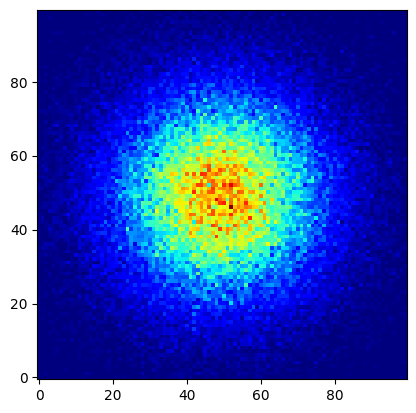

In [56]:
fig, ax = plt.subplots(1, 1)
ax.imshow(x_train[indx].reshape(100, 100), cmap=plt.cm.jet, origin='lower')
plt.show()

In [94]:
y_train[indx]

array([   92.71517578, 71718.81843113])

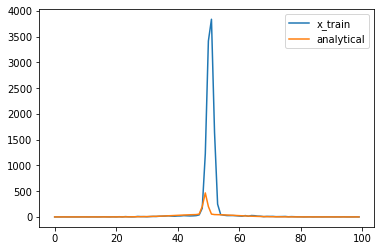

In [95]:
x = np.linspace(-49, 50, 100)
y = np.linspace(-49, 50, 100)
x, y = np.meshgrid(x, y)
length = 100

analytical_for_x_train_im = analytical_eq((x,y),0,0,y_train[indx][1],y_train[indx][0])
analytical_for_x_train_im = np.reshape(analytical_for_x_train_im,(length,length))

plt.plot(np.arange(len(x_train[indx])),x_train[indx,row],label = "x_train")
plt.plot(np.arange(len(x_train[indx])),analytical_for_x_train_im[row],label = "analytical")
plt.legend()

In [ ]:
# temp mse: 10.220974809607364
# atoms mse: 235086.60269962501
# temp rmse: 3.197025931957288
# atoms rmse: 484.8573013780704
# temp mae: 2.272125123170204
# atoms mae: 267.91944761821696

### Functions

In [3]:
def analytical_eq(xy,xo,yo,No,T):   
    x, y = xy
    
    Nex = 100000-No
    
    out = (No/math.pi)*np.exp(-(x-xo)**2)*np.exp(-(y-yo)**2) + (Nex/(2*math.pi*T))*np.exp((-(x-xo)**2)/(2*T))*np.exp((-(y-yo)**2)/(2*T))

    # out = (out - np.min(out)) / np.max(out)
    return out.ravel()

### generate im func

In [312]:
num_atoms = 100000
length = 100
dimensions = 2
        
        
def generate_image(length,num_atoms,dimensions,temp):
    '''
    generate image using sampling
    '''

    x_list = []
    y_list = []
    
    trans_temp = (num_atoms/(2*1*1.645))**(1/dimensions)
    # temp = np.random.uniform(trans_temp//2,int(trans_temp*2))  
    temp_ratio = temp/trans_temp

    num_BEC_atoms = 0
    if temp < trans_temp:
        num_BEC_atoms = num_atoms*(1-(temp/trans_temp)**dimensions)
        
    count = 0
    
    for i in range(num_atoms):
        probability = np.random.rand()
        if temp_ratio >1 :
            temp_ratio = 1
        BEC_probability = (1-(temp_ratio)**dimensions)
        if probability <= BEC_probability:
            count += 1
            x_list.append(np.random.normal(0,math.sqrt(1/2)))
            y_list.append(np.random.normal(0,math.sqrt(1/2)))

        else:
            x_list.append(np.random.normal(0,math.sqrt(temp)))
            y_list.append(np.random.normal(0,math.sqrt(temp)))



    hist = np.histogram2d(x_list,y_list,length,range = [(-49,50),(-49,50)])[0]
    hist = hist.tolist()
    return hist,temp,num_BEC_atoms,count

### Low Temp

In [59]:
test_im_count = 100
test_ims = []
labs = []

temp = 50


for i in range(test_im_count):
    curr_im, t, n, count = generate_image(length,num_atoms,dimensions,temp)
    
    test_ims.append(np.asarray(curr_im))
    labs.append((t,n,count))

test_ims = np.stack(test_ims)
labs = np.stack(labs)

In [60]:
mean_test_im = np.mean(test_ims,axis = 0)

In [66]:
std_err = np.std(test_ims,axis = 0)/np.sqrt(test_im_count)

In [67]:
num_atoms = 100000
dimensions = 2

x = np.linspace(-49, 50, 100)
y = np.linspace(-49, 50, 100)
x, y = np.meshgrid(x, y)


trans_temp = (num_atoms/(2*1*1.645))**(1/dimensions)
num_BEC_atoms = 0
if temp < trans_temp:
    num_BEC_atoms = num_atoms*(1-(temp/trans_temp)**dimensions)

analytical = analytical_eq((x,y),0,0,num_BEC_atoms,temp)

In [68]:
analytical = np.reshape(analytical,(length,length))

Text(0.5, 1.0, 'Low Temp')

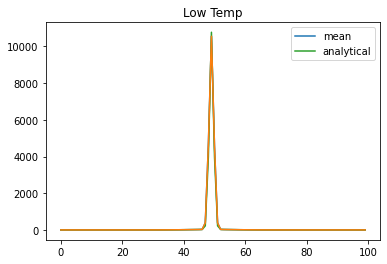

In [69]:
#mean gaussian

row = 50

plt.plot(np.arange(len(mean_test_im[0])),mean_test_im[row],label = "mean")
plt.errorbar(np.arange(len(mean_test_im[0])),mean_test_im[row],yerr = std_err[row])
plt.plot(np.arange(len(mean_test_im[0])),analytical[row],label = "analytical")
plt.legend()
plt.title("Low Temp")

### Medium Temp

In [12]:
test_im_count = 100
test_ims = []
labs = []

temp = 170


for i in range(test_im_count):
    curr_im, t, n, count = generate_image(length,num_atoms,dimensions,temp)
    
    test_ims.append(np.asarray(curr_im))
    labs.append((t,n,count))

test_ims = np.stack(test_ims)
labs = np.stack(labs)

In [13]:
mean_test_im = np.mean(test_ims,axis = 0)

In [14]:
std_err = np.std(test_ims,axis = 0)/np.sqrt(test_im_count)

In [15]:
num_atoms = 100000
dimensions = 2

x = np.linspace(-49, 50, 100)
y = np.linspace(-49, 50, 100)
x, y = np.meshgrid(x, y)


trans_temp = (num_atoms/(2*1*1.645))**(1/dimensions)
num_BEC_atoms = 0
if temp < trans_temp:
    num_BEC_atoms = num_atoms*(1-(temp/trans_temp)**dimensions)

analytical = analytical_eq((x,y),0,0,num_BEC_atoms,temp)

In [16]:
analytical = np.reshape(analytical,(length,length))

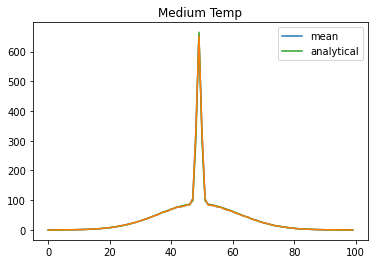

In [17]:
#mean gaussian

row = 50

plt.plot(np.arange(len(mean_test_im[0])),mean_test_im[row],label = "mean")
plt.errorbar(np.arange(len(mean_test_im[0])),mean_test_im[row],yerr = std_err[row])
plt.plot(np.arange(len(mean_test_im[0])),analytical[row],label = "analytical")
plt.title("Medium Temp")
plt.legend()

### High temp

In [77]:
test_im_count = 100
test_ims = []
labs = []

temp = 200


for i in range(test_im_count):
    curr_im, t, n, count = generate_image(length,num_atoms,dimensions,temp)
    
    test_ims.append(np.asarray(curr_im))
    labs.append((t,n,count))

test_ims = np.stack(test_ims)
labs = np.stack(labs)

In [78]:
mean_test_im = np.mean(test_ims,axis = 0)

In [79]:
std_err = np.std(test_ims,axis = 0)/np.sqrt(test_im_count)

In [80]:
num_atoms = 100000
dimensions = 2

x = np.linspace(-49, 50, 100)
y = np.linspace(-49, 50, 100)
x, y = np.meshgrid(x, y)


trans_temp = (num_atoms/(2*1*1.645))**(1/dimensions)
num_BEC_atoms = 0
if temp < trans_temp:
    num_BEC_atoms = num_atoms*(1-(temp/trans_temp)**dimensions)

analytical = analytical_eq((x,y),0,0,num_BEC_atoms,temp)

In [81]:
analytical = np.reshape(analytical,(length,length))

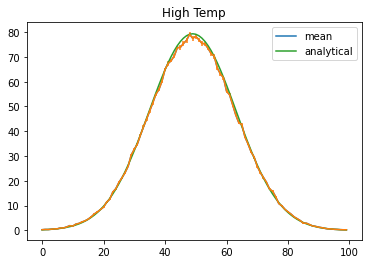

In [83]:
#mean gaussian

row = 50

plt.plot(np.arange(len(mean_test_im[0])),mean_test_im[row],label = "mean")
plt.errorbar(np.arange(len(mean_test_im[0])),mean_test_im[row],yerr = std_err[row])
plt.plot(np.arange(len(mean_test_im[0])),analytical[row],label = "analytical")
plt.title("High Temp")
plt.legend()

# Checking Variances

If you want to run these cells to make sure that the variance of the Gaussians these functions produce are correct, you need to change the generate image function so that it only produces images with one temperature.

In [ ]:
test_ims.shape

In [ ]:
mean_test_im = np.mean(test_ims,axis = 0)

In [ ]:
summ_all_mean = np.sum(mean_test_im)
summ_all_mean

In [ ]:
pxy = mean_test_im/summ_all_mean
px = np.sum(pxy,axis = 1)
res = px * np.linspace(-49, 50, 100)
expected_val_x = np.sum(res)
expected_val_x2 = np.sum(px * np.linspace(-49, 50, 100) ** 2)

In [ ]:
np.sum(px)

In [ ]:
expected_val_x

In [ ]:
expected_val_x2

In [ ]:
var_sampling = expected_val_x2 - expected_val_x**2

In [ ]:
num_atoms = 100000
dimensions = 2
# temp = 300

trans_temp = (num_atoms/(2*1*1.645))**(1/dimensions)
num_BEC_atoms = num_atoms*(1-(temp/trans_temp)**dimensions)

actual = analytical_eq((x,y),0,0,num_BEC_atoms,temp)

In [ ]:
summ_actual = np.sum(actual)
summ_actual

In [ ]:
pxy_actual = actual/summ_actual
px_actual = np.sum(pxy_actual,axis = 1)
res = px_actual * np.linspace(-49, 50, 100)
expected_val_x_actual = np.sum(res)
expected_val_x2_actual = np.sum(px_actual * np.linspace(-49, 50, 100) ** 2)

In [ ]:
expected_val_x_actual

In [ ]:
expected_val_x2_actual

In [ ]:
var_actual = expected_val_x2_actual - expected_val_x_actual**2
var_actual

In [ ]:
# length = 100
# actual = np.reshape(actual,(length,length))
# actual.shape

In [ ]:
print(var_sampling,var_actual)

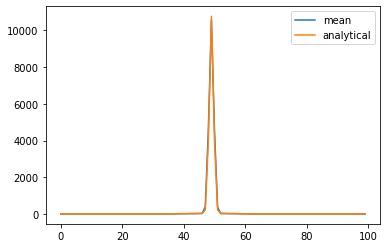

In [395]:
#mean gaussian

row = 50

plt.plot(np.arange(len(mean_test_im[0])),mean_test_im[row],label = "mean")
# plt.errorbar(np.arange(len(mean_test_im[0])),mean_test_im[row],yerr = std_err[row])
plt.plot(np.arange(len(mean_test_im[0])),actual[row],label = "analytical")
plt.legend()

# Curve Fitting

In [64]:
#reload data

print("loading data...")
in_file = bz2.BZ2File("./generated_data/full_generated_data.bz2",'rb')
data = pickle.load(in_file)
in_file.close()

print("data loaded.")

x_train = np.asarray(data[0])
y_train = np.asarray(data[1])
x_test = np.asarray(data[2])
y_test = np.asarray(data[3])

tmp_x_test = copy.copy(x_test)
tmp_y_test = copy.copy(y_test)


loading data...
data loaded.


### Experimenting with Minimize

In [5]:
# 8 batches of size 500 for 4000 test images
batch_size = 500
processes = 8

In [6]:
#reload data
import concurrent.futures

from fit_with_mp import FitMP

fitmp = FitMP()

ims = [tmp_x_test[batch*batch_size:(batch+1)*batch_size] for batch in range(processes)]
labs = [tmp_y_test[batch*batch_size:(batch+1)*batch_size] for batch in range(processes)]

with concurrent.futures.ProcessPoolExecutor() as executor:
    out = executor.map(fitmp.fit_preds_for_batch,ims,labs)

out = np.array(list(out))

In [7]:
out.shape

(8, 500, 2)

In [8]:
full_preds = np.concatenate(out.copy(),axis = 0)

In [9]:
full_preds.shape

(4000, 2)

In [10]:
fit_T_rmse = mean_squared_error(full_preds[:,0],tmp_y_test[:len(full_preds),0],squared = False)
print(fit_T_rmse)

2.6527404670466903


In [11]:
fit_N_rmse = mean_squared_error(full_preds[:,1],tmp_y_test[:len(full_preds),1],squared = False)
print(fit_N_rmse)

404.5241436296331


In [92]:
x_scaler = MinMaxScaler(feature_range = (0,1))
x_train = [x_scaler.fit_transform(x_train[i]) for i in range(len(x_train))]
x_test = [x_scaler.fit_transform(x_test[i]) for i in range(len(x_test))]

#scale labels to be between 0 and 1
y_scaler = MinMaxScaler(feature_range = (0,1))
y_train = y_scaler.fit_transform(y_train)
y_test = y_scaler.fit_transform(y_test)

x_train = np.asarray(x_train)
x_test = np.asarray(x_test)

y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

ml_model = tf.keras.models.load_model('../../big_models/BEC_model_conv')

In [94]:
ml_preds = ml_model.predict(x_test)
scaled_ml_preds = ml_preds
ml_preds = y_scaler.inverse_transform(ml_preds)

125/125 [==============================] - 1s 8ms/step


In [95]:
x = np.linspace(-49, 50, 100)
y = np.linspace(-49, 50, 100)
x, y = np.meshgrid(x, y)

In [16]:
#rmse and mae comparisons

ans = []

for i in range(len(full_preds)):

    fit_rmse_for_this_im = mean_squared_error(analytical_eq((x,y),0,0,*full_preds[i][::-1]),tmp_x_test[i].ravel(),squared = False)
    ml_rmse_for_this_im = mean_squared_error(analytical_eq((x,y),0,0,*ml_preds[i][::-1]),tmp_x_test[i].ravel(),squared = False)
    analytical_rmse_for_this_im = mean_squared_error(analytical_eq((x,y),0,0,*tmp_y_test[i][::-1]),tmp_x_test[i].ravel(),squared = False)
    
    fit_mae_for_this_im = mean_absolute_error(analytical_eq((x,y),0,0,*full_preds[i][::-1]),tmp_x_test[i].ravel())
    ml_mae_for_this_im = mean_absolute_error(analytical_eq((x,y),0,0,*ml_preds[i][::-1]),tmp_x_test[i].ravel())
    analytical_mae_for_this_im = mean_absolute_error(analytical_eq((x,y),0,0,*tmp_y_test[i][::-1]),tmp_x_test[i].ravel())

    if (fit_rmse_for_this_im < analytical_rmse_for_this_im and fit_mae_for_this_im < analytical_mae_for_this_im) and (fit_rmse_for_this_im < ml_rmse_for_this_im and fit_mae_for_this_im < ml_mae_for_this_im):
        ans.append(True)
print(all(ans))

True


In [66]:
#get original curve fitting fit

im_num = 32
row = 47

og_popt, _ = opt.curve_fit(analytical_eq, (x, y), tmp_x_test[im_num].ravel(), p0=(0,0,50000,175))

In [90]:
plt.plot(np.arange(100),analytical_eq((x,y),0,0,*tmp_y_test[im_num][::-1]).reshape(100,100)[row],label = "Analytical Model")
# plt.plot(np.arange(100),analytical_eq((x, y), 0,0,*og_popt[2:]).reshape(100,100)[row],label = "old fit")
plt.plot(np.arange(100),analytical_eq((x,y),0,0,*full_preds[im_num][::-1]).reshape(100,100)[row],label = "new fit")
plt.plot(np.arange(100),analytical_eq((x,y),0,0,*ml_preds[im_num][::-1]).reshape(100,100)[row],label = "ML Model")
plt.plot(np.arange(100),tmp_x_test[im_num,row],label = "Noisy Image")
plt.xlabel("Pixel")
plt.ylabel("Density")
plt.legend()

NameError: name 'im_num' is not defined

### Original

[-2.73114620e-01  1.08314250e-15  2.36668149e+02]


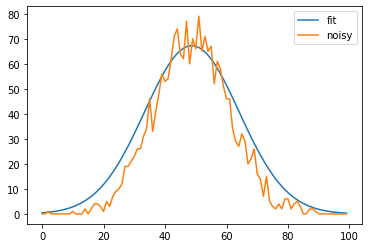

In [154]:
x = np.linspace(-49, 50, 100)
y = np.linspace(-49, 50, 100)
# x, y = np.meshgrid(x, y)

preds = []
origins = []
for i,pair in enumerate(zip(tmp_x_test[:1],tmp_y_test[:1])):
    im,labs = pair
    initial_guess = (0,50000,175)
    popts = []
    for row in im[45:46]:
        if not all(row == 0):
            popt, _ = opt.curve_fit(analytical_eq_x, x, row, p0=initial_guess,maxfev = 5000,bounds = ([-10,0,60],[10,100000,400]))
            print(popt)
            popts.append(popt)            
            
            plt.plot(np.arange(100),analytical_eq_x(x,*popt),label = "fit")
            plt.plot(np.arange(100),row,label = "noisy")
            plt.legend()

    # for col in im.T[45:46]:
    #     if not all(col == 0):
    #         popt, _ = opt.curve_fit(analytical_eq_x, y, col, p0=initial_guess,maxfev = 5000)
    #         popts.append(popt)
    # xo,yo = popt[:2]
    # pred_No = popt[2]
    # pred_T = popt[3]
    # if pred_No < 0:
    #     pred_No = 0
    # if pred_T < 0:
    #     pred_T = 0
    # preds.append((pred_T,pred_No))
    # origins.append((xo,yo))
    # print(np.mean(popts,axis = 0))        
preds = np.asarray(preds)

In [150]:
tmp_y_test[:1]

array([[  150.42190044, 25557.99864109]])

In [77]:
x_scaler = MinMaxScaler(feature_range = (0,1))
x_train = [x_scaler.fit_transform(x_train[i]) for i in range(len(x_train))]
x_test = [x_scaler.fit_transform(x_test[i]) for i in range(len(x_test))]

#scale labels to be between 0 and 1
y_scaler = MinMaxScaler(feature_range = (0,1))
y_train = y_scaler.fit_transform(y_train)
y_test = y_scaler.fit_transform(y_test)



ml_model = tf.keras.models.load_model('../../big_models/BEC_model_conv')

In [78]:
x_train = np.asarray(x_train)
x_test = np.asarray(x_test)

y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [79]:
x_test.shape

(4000, 100, 100)

In [80]:
ml_preds = ml_model.predict(x_test)
ml_preds = y_scaler.inverse_transform(ml_preds)

  2/125 [..............................] - ETA: 12s

2023-03-18 21:41:37.641258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 1s 9ms/step


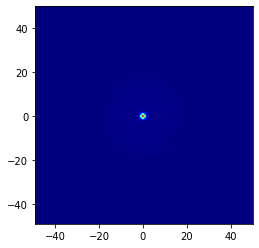

In [81]:
check_indx = 0

data_fitted = analytical_eq((x, y), *origins[check_indx],*preds[check_indx][::-1])

fig, ax = plt.subplots(1, 1)
ax.imshow(tmp_x_test[check_indx].reshape(100, 100), cmap=plt.cm.jet, origin='lower',
    extent=(x.min(), x.max(), y.min(), y.max()))
# ax.contour(x, y, data_fitted.reshape(100, 100),10, colors='w')
plt.show()

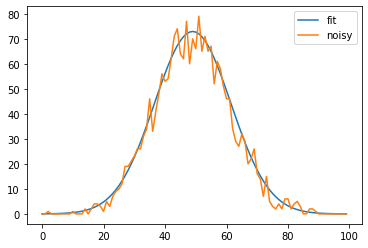

In [82]:
check = data_fitted.reshape(100,100)
row = 45

# analytical solution used curve fitting for origin

analytical_soln = analytical_eq((x,y),*origins[check_indx],*tmp_y_test[check_indx][::-1])
analytical_soln_im = np.reshape(analytical_soln,(length,length))
fit_im = analytical_eq((x, y), *origins[check_indx],*preds[check_indx][::-1])
fit_im = np.reshape(fit_im,(length,length))
ml_im = analytical_eq((x, y), *origins[check_indx],*ml_preds[check_indx][::-1])
ml_im = np.reshape(ml_im,(length,length))

plt.plot(np.arange(len(check[0])),fit_im[row],label = "fit")
plt.plot(np.arange(len(check[0])),tmp_x_test[check_indx,row],label = "noisy")
# plt.plot(np.arange(len(check[0])),analytical_soln_im[row],label = "analytical")
# plt.plot(np.arange(len(check[0])),ml_im[row],label = "ml")
plt.legend()

In [83]:
preds[check_indx]

array([  154.34514934, 25547.99864109])

In [84]:
tmp_y_test[check_indx]

array([  150.42190044, 25557.99864109])

In [85]:
ml_preds[check_indx]

array([  150.39822, 25579.043  ], dtype=float32)

In [86]:
fit_T_rmse = mean_squared_error(preds[:,0],tmp_y_test[:,0],squared = False)
fit_T_rmse

5.035572792931

In [87]:
fit_N_rmse = mean_squared_error(preds[:,1],tmp_y_test[:,1],squared = False)
fit_N_rmse

7.545543671572482

In [88]:
ml_T_rmse = mean_squared_error(ml_preds[:,0],tmp_y_test[:,0],squared = False)
ml_T_rmse

0.2520388658002403

In [89]:
ml_N_rmse = mean_squared_error(ml_preds[:,1],tmp_y_test[:,1],squared = False)
ml_N_rmse

57.79771140746977

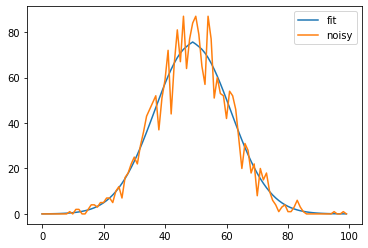

In [90]:
check = data_fitted.reshape(100,100)
row = 46

# analytical solution used curve fitting for origin

analytical_soln = analytical_eq((x,y),*origins[check_indx],*tmp_y_test[check_indx][::-1])
analytical_soln_im = np.reshape(analytical_soln,(length,length))
fit_im = analytical_eq((x, y), *origins[check_indx],*preds[check_indx][::-1])
fit_im = np.reshape(fit_im,(length,length))
ml_im = analytical_eq((x, y), *origins[check_indx],*ml_preds[check_indx][::-1])
ml_im = np.reshape(ml_im,(length,length))

plt.plot(np.arange(len(check[0])),fit_im[row],label = "fit")
plt.plot(np.arange(len(check[0])),tmp_x_test[check_indx,row],label = "noisy")
plt.legend()

### Checking Residuals

In [19]:
#maybe break up resiudal graphs into based on temp

In [20]:
fit_residuals = full_preds - tmp_y_test[:len(full_preds)]

Text(0.5, 1.0, 'Fit Temperature Residuals')

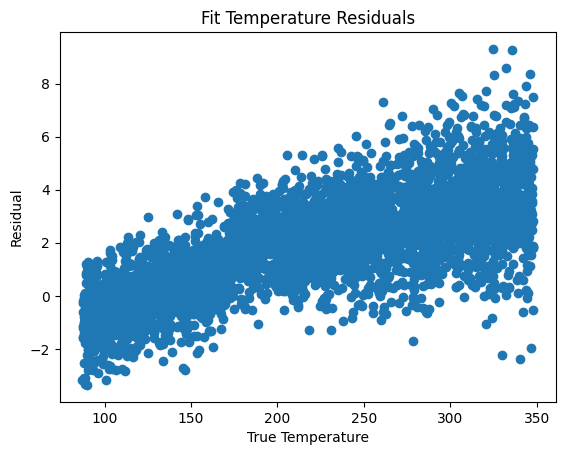

In [21]:
#fit temperature residuals
plt.scatter(tmp_y_test[:len(full_preds),0],fit_residuals[:,0])
plt.xlabel("True Temperature")
plt.ylabel("Residual")
plt.title("Fit Temperature Residuals")

Text(0.5, 1.0, 'Fit Nc Residuals')

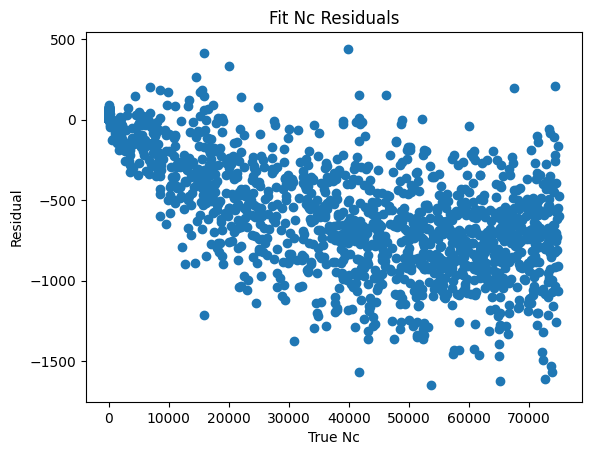

In [22]:
#fit Nc residuals
plt.scatter(tmp_y_test[:len(full_preds),1],fit_residuals[:,1])
plt.xlabel("True Nc")
plt.ylabel("Residual")
plt.title("Fit Nc Residuals")

In [23]:
ml_residuals = ml_preds - tmp_y_test

Text(0.5, 1.0, 'ML Temperature Residuals')

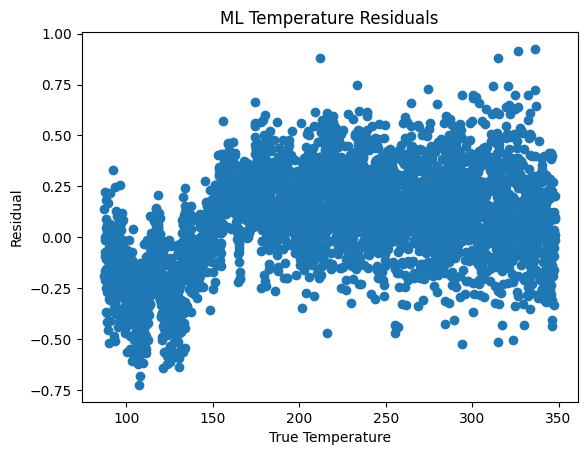

In [24]:
#ml temperature residuals
plt.scatter(tmp_y_test[:,0],ml_residuals[:,0])
plt.xlabel("True Temperature")
plt.ylabel("Residual")
plt.title("ML Temperature Residuals")

Text(0.5, 1.0, 'ML Nc Residuals')

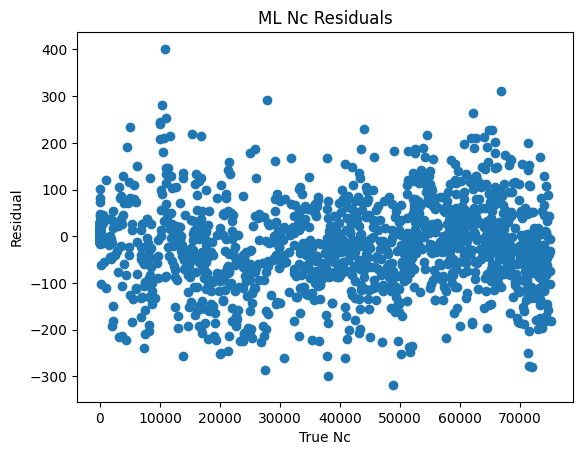

In [25]:
#ML Nc residuals
plt.scatter(tmp_y_test[:,1],ml_residuals[:,1])
plt.xlabel("True Nc")
plt.ylabel("Residual")
plt.title("ML Nc Residuals")

### Predicted vs. Actual Graphs

Text(0.5, 1.0, 'SciPy Fit Predicted Temperature vs. True Temperature')

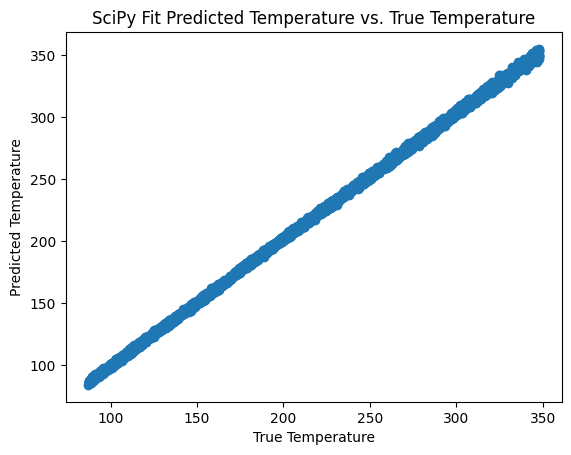

In [87]:
#fit temperature residuals
plt.scatter(tmp_y_test[:,0],full_preds[:,0])
plt.xlabel("True Temperature")
plt.ylabel("Predicted Temperature")
plt.title("SciPy Fit Predicted Temperature vs. True Temperature")

Text(0.5, 1.0, 'ML Predicted Temperature vs. True Temperature')

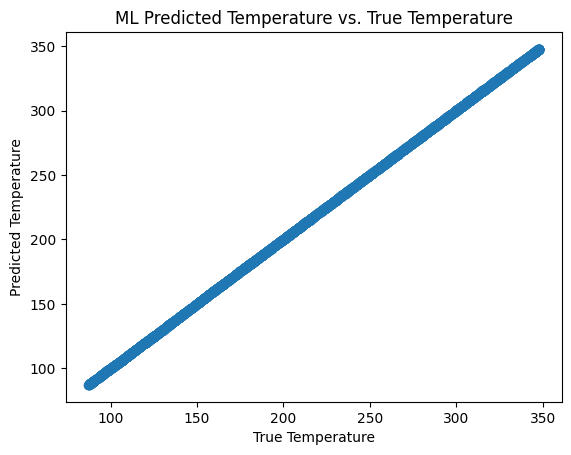

In [88]:
#fit temperature residuals
plt.scatter(tmp_y_test[:,0],ml_preds[:,0])
plt.xlabel("True Temperature")
plt.ylabel("Predicted Temperature")
plt.title("ML Predicted Temperature vs. True Temperature")

Text(0.5, 1.0, 'ML Predicted Temperature vs. True Temperature')

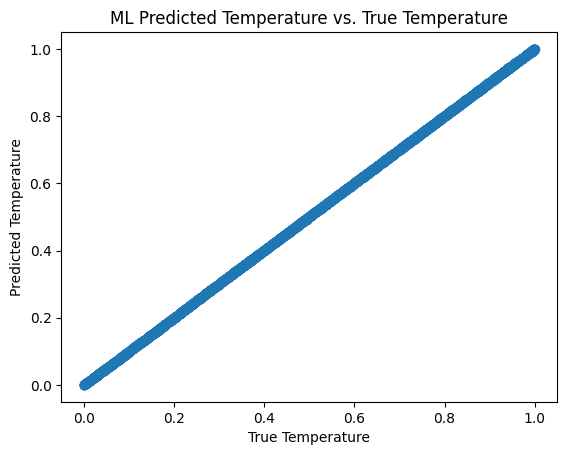

In [97]:
#fit temperature residuals
plt.scatter(y_test[:,0],scaled_ml_preds[:,0])
plt.xlabel("True Temperature")
plt.ylabel("Predicted Temperature")
plt.title("ML Predicted Temperature vs. True Temperature")

Text(0.5, 1.0, 'SciPy Fit Predicted Condensate Number vs. True Condensate Number')

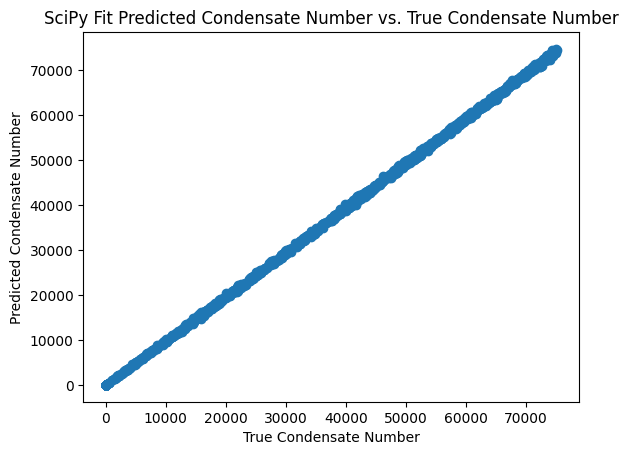

In [89]:
#fit temperature residuals
plt.scatter(tmp_y_test[:,1],full_preds[:,1])
plt.xlabel("True Condensate Number")
plt.ylabel("Predicted Condensate Number")
plt.title("SciPy Fit Predicted Condensate Number vs. True Condensate Number")

Text(0.5, 1.0, 'ML Predicted Condensate Number vs. True Condensate Number')

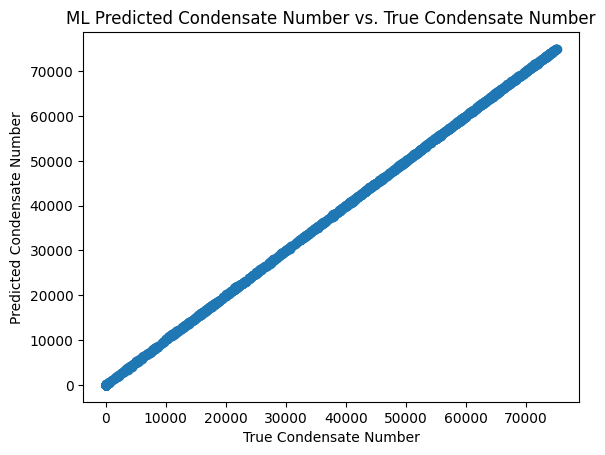

In [90]:
#fit temperature residuals
plt.scatter(tmp_y_test[:,1],ml_preds[:,1])
plt.xlabel("True Condensate Number")
plt.ylabel("Predicted Condensate Number")
plt.title("ML Predicted Condensate Number vs. True Condensate Number")

Text(0.5, 1.0, 'ML Predicted Condensate Number vs. True Condensate Number')

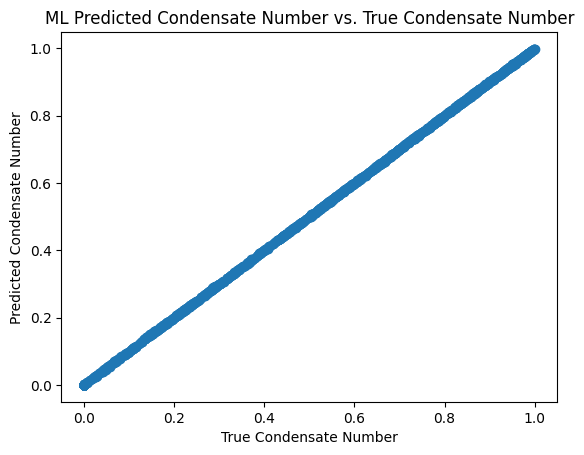

In [98]:
#fit temperature residuals
plt.scatter(y_test[:,1],scaled_ml_preds[:,1])
plt.xlabel("True Condensate Number")
plt.ylabel("Predicted Condensate Number")
plt.title("ML Predicted Condensate Number vs. True Condensate Number")

### Model Stats

#### Fit

In [26]:
fit_T_rmse = mean_squared_error(full_preds[:,0],tmp_y_test[:len(full_preds),0],squared = False)
print(fit_T_rmse)

2.6527404670466903


In [27]:
fit_N_rmse = mean_squared_error(full_preds[:,1],tmp_y_test[:len(full_preds),1],squared = False)
print(fit_N_rmse)

404.5241436296331


In [28]:
fit_T_mae = mean_absolute_error(full_preds[:,0],tmp_y_test[:len(full_preds),0])
print(fit_T_mae)

2.1482394613027123


In [29]:
fit_N_mae = mean_absolute_error(full_preds[:,1],tmp_y_test[:len(full_preds),1])
print(fit_N_mae)

210.75940521426668


#### ML

In [30]:
ml_T_rmse = mean_squared_error(ml_preds[:,0],tmp_y_test[:len(ml_preds),0],squared = False)
print(ml_T_rmse)

0.2520388658002403


In [31]:
ml_N_rmse = mean_squared_error(ml_preds[:,1],tmp_y_test[:len(ml_preds),1],squared = False)
print(ml_N_rmse)

57.79771140746977


In [32]:
ml_T_mae = mean_absolute_error(ml_preds[:,0],tmp_y_test[:len(ml_preds),0])
print(ml_T_mae)

0.2054023649317868


In [33]:
ml_N_mae = mean_absolute_error(ml_preds[:,1],tmp_y_test[:len(ml_preds),1])
print(ml_N_mae)

31.435161644166975


In [99]:
# scaled ml

In [100]:
ml_T_rmse = mean_squared_error(scaled_ml_preds[:,0],y_test[:len(scaled_ml_preds),0],squared = False)
print(ml_T_rmse)

ml_N_rmse = mean_squared_error(scaled_ml_preds[:,1],y_test[:len(scaled_ml_preds),1],squared = False)
print(ml_N_rmse)

0.0009659880298614939
0.0007697793130096428


# Testing numpy.random.normal

In [284]:
xl_coord = -49
xr_coord = 50
x = np.linspace(xl_coord, xr_coord, 100)

In [285]:
def simpleGaussian(x,mu,var):
    return (1/np.sqrt(2*math.pi*var))*np.exp(-(x-mu)**2/(2*var))

In [286]:
T = 300
simpleGaussian(0,0,T)

0.023032943298089033

In [287]:
analytical_xs = list(map(simpleGaussian,x,np.zeros(bins),[T for _ in range(bins)]))

In [288]:
analytical_xs = (analytical_xs - np.min(analytical_xs))/np.max(analytical_xs)

In [289]:
analytical_xs.shape

(100,)

In [290]:
bins = 100
samples = 100000
xs = []
for _ in range(samples):
    xs.append(np.random.normal(0,np.sqrt(T)))
xs = np.array(xs)
xs = np.histogram(xs,bins)#range = (xl_coord,xr_coord)) # HERE IS THE ISSUE
xs = xs[0]

In [291]:
xs = (xs - np.min(xs))/np.max(xs)

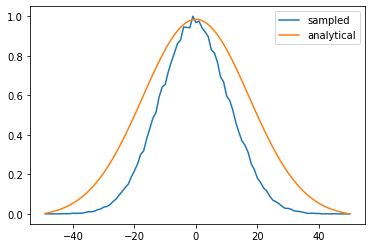

In [292]:
plt.plot(x,xs,label = "sampled")
plt.plot(x,analytical_xs,label = "analytical")
plt.legend()

# Simple Images

In [16]:
x = np.linspace(-49, 50, 100)
y = np.linspace(-49, 50, 100)
x, y = np.meshgrid(x, y)

def generate_simple_image(xy,xo,yo,No,T,random_amp):
    '''
    generate image without sampling
    '''
    
    x, y = xy
    
    Nex = 100000-No
    
    out = (No/math.pi)*np.exp(-(x-xo)**2)*np.exp(-(y-yo)**2) + (Nex/(2*math.pi*T))*np.exp((-(x-xo)**2)/(2*T))*np.exp((-(y-yo)**2)/(2*T))
    
    tmp = out.copy()
    for row in range(len(out)):
        for col in range(len(out[0])):
            out[row,col] += random_amp * np.random.normal()

    
    

    return out

In [17]:
#generate simple images

random_amp = 10

num_atoms = 100000
num_ims = 800
dimensions = 2

trans_temp = (num_atoms/(2*1*1.645))**(1/dimensions)

x_simple_data = []
y_simple_data = []

for _ in range(num_ims):
    temp = np.random.uniform(trans_temp//2,int(trans_temp*2))
    num_BEC_atoms = 0
    if temp < trans_temp:
        num_BEC_atoms = num_atoms*(1-(temp/trans_temp)**dimensions)
    curr_img = generate_simple_image((x,y),0,0,num_BEC_atoms,temp,random_amp)
        
    x_simple_data.append(curr_img)
    y_simple_data.append((temp,num_BEC_atoms))

x_simple_data = np.array(x_simple_data)
y_simple_data = np.array(y_simple_data)

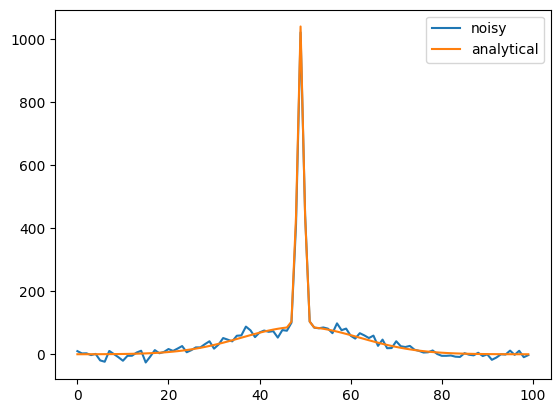

In [24]:
indx = 5
row = 50
plt.plot(np.arange(100),x_simple_data[indx,row],label = "noisy")
plt.plot(np.arange(100),analytical_eq((x,y),0,0,*y_simple_data[indx][::-1]).reshape(100,100)[row],label = "analytical")
plt.legend()

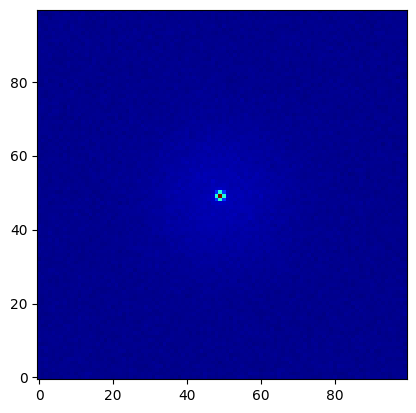

In [32]:
fig, ax = plt.subplots(1, 1)
ax.imshow(x_simple_data[indx].reshape(100, 100), cmap=plt.cm.jet, origin='lower')
plt.show()

In [30]:
o_file = "./generated_data/full_generated_data_simple.bz2"
out = bz2.BZ2File(o_file,'wb')
simple_data_tup = (x_simple_data[:400],y_simple_data[:400],x_simple_data[400:],y_simple_data[400:])
pickle.dump(simple_data_tup,out)
out.close()

# Fitting Simple Images

In [33]:
print("loading data...")
in_file = bz2.BZ2File("./generated_data/full_generated_data_simple.bz2",'rb')
data = pickle.load(in_file)
in_file.close()

print("data loaded.")

x_train_simple = np.asarray(data[0])
y_train_simple = np.asarray(data[1])
x_test_simple = np.asarray(data[2])
y_test_simple = np.asarray(data[3])
tmp_x_test_simple = copy.copy(x_test_simple)
tmp_y_test_simple = copy.copy(y_test_simple)

loading data...
data loaded.


### Curve fit

In [34]:
# 8 batches of size 50 for 400 test images
batch_size = 50
processes = 8

#reload data
import concurrent.futures

from fit_with_mp import FitMP

fitmp = FitMP()

ims = [tmp_x_test_simple[batch*batch_size:(batch+1)*batch_size] for batch in range(processes)]
labs = [tmp_y_test_simple[batch*batch_size:(batch+1)*batch_size] for batch in range(processes)]

with concurrent.futures.ProcessPoolExecutor() as executor:
    out = executor.map(fitmp.fit_preds_for_batch,ims,labs)

out = np.array(list(out))

In [35]:
out.shape
full_preds_simple = np.concatenate(out.copy(),axis = 0)

In [36]:
full_preds_simple.shape

(400, 2)

In [37]:
fit_T_rmse = mean_squared_error(full_preds_simple[:,0],tmp_y_test_simple[:len(full_preds),0],squared = False)
print(fit_T_rmse)

fit_N_rmse = mean_squared_error(full_preds_simple[:,1],tmp_y_test_simple[:len(full_preds),1],squared = False)
print(fit_N_rmse)

2.4562777648510523
23.28884367866845


In [27]:
#ml stats for amplitude 1 noise

# temp rmse: 0.24052850025537567
# atoms rmse: 69.76444420759155

In [ ]:
#ml stats for amplitude 10 noise

# temp rmse: 0.19080853470339487
# atoms rmse: 68.25378232088842

# Countour Plots for Symposium

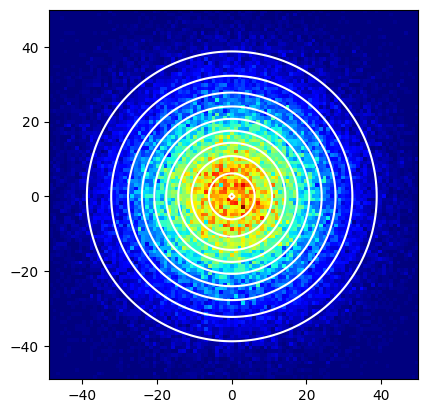

In [91]:
data_fitted = analytical_eq((x, y),0,0,*ml_preds[2][::-1])

fig, ax = plt.subplots(1, 1)
ax.imshow(x_train[2].reshape(100, 100), cmap=plt.cm.jet, origin='lower',
    extent=(x.min(), x.max(), y.min(), y.max()))
ax.contour(x, y, data_fitted.reshape(100, 100),10, colors='w')
plt.show()